## 1. Download Libraries

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vcop1618
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vcop1618
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6c53a4ed7a6d4da91e6d19a60e0d8ee8604f837dced3d32adad80a4d0708edc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-rzsoc34a/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
!nvidia-smi

Wed Dec  3 16:05:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.9.0+cu126


/tmp/ipython-input-189856270.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


## 2. Load the model

In [ ]:
import clip

# Hiển thị danh sách các model sẵn có
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 119MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## 3. Image Preprocessing

In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa17d3cdbc0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## 4. Text Preprocessing

In [ ]:
clip.tokenize("Hello World")

tensor([[49406,  3306,  1002, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## 5. Setting up input images and texts

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fashion-product-images-small' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-small


In [ ]:
# dataset_dir là đường dẫn cache
print("Dataset is stored at:", path)


Dataset is stored at: /kaggle/input/fashion-product-images-small


In [ ]:
import pandas as pd
import os

# Folder dataset
dataset_dir = "/kaggle/input/fashion-product-images-small"
images_dir = os.path.join(dataset_dir, "images")
csv_path = os.path.join(dataset_dir, "styles.csv")

# Load CSV
df = pd.read_csv(csv_path, sep=',', quotechar='"', on_bad_lines='skip')

print(df.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


In [ ]:
print(df.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


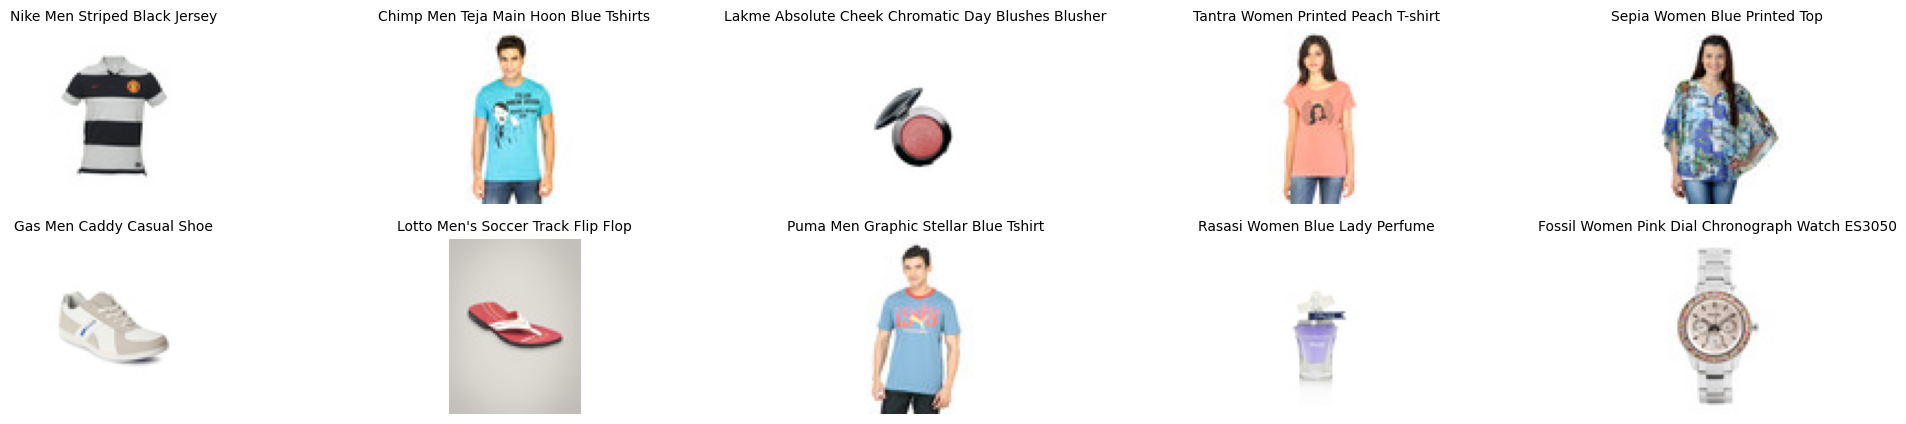

In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

original_images = []  # lưu PIL Image gốc
images = []           # lưu tensor đã preprocess
texts = []            # lưu caption

# Hiển thị 10 ảnh gần nhất + caption
sample_df = df.tail(10)

plt.figure(figsize=(25,5))
for i, row in enumerate(sample_df.itertuples()):
    img_filename = f"{getattr(row, 'id')}.jpg"
    img_path = os.path.join(images_dir, img_filename)

    if os.path.exists(img_path):
        img = Image.open(img_path).convert("RGB")  # convert để chắc chắn
        plt.subplot(2,5,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(getattr(row, "productDisplayName"), fontsize=10)

        original_images.append(img)
        images.append(preprocess(img))  # preprocess cho CLIP
        texts.append(getattr(row, "productDisplayName"))  # caption
    else:
        print(f"Image {img_filename} not found!")

plt.show()


## 6. Train models

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

Calculate cosine similarity

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

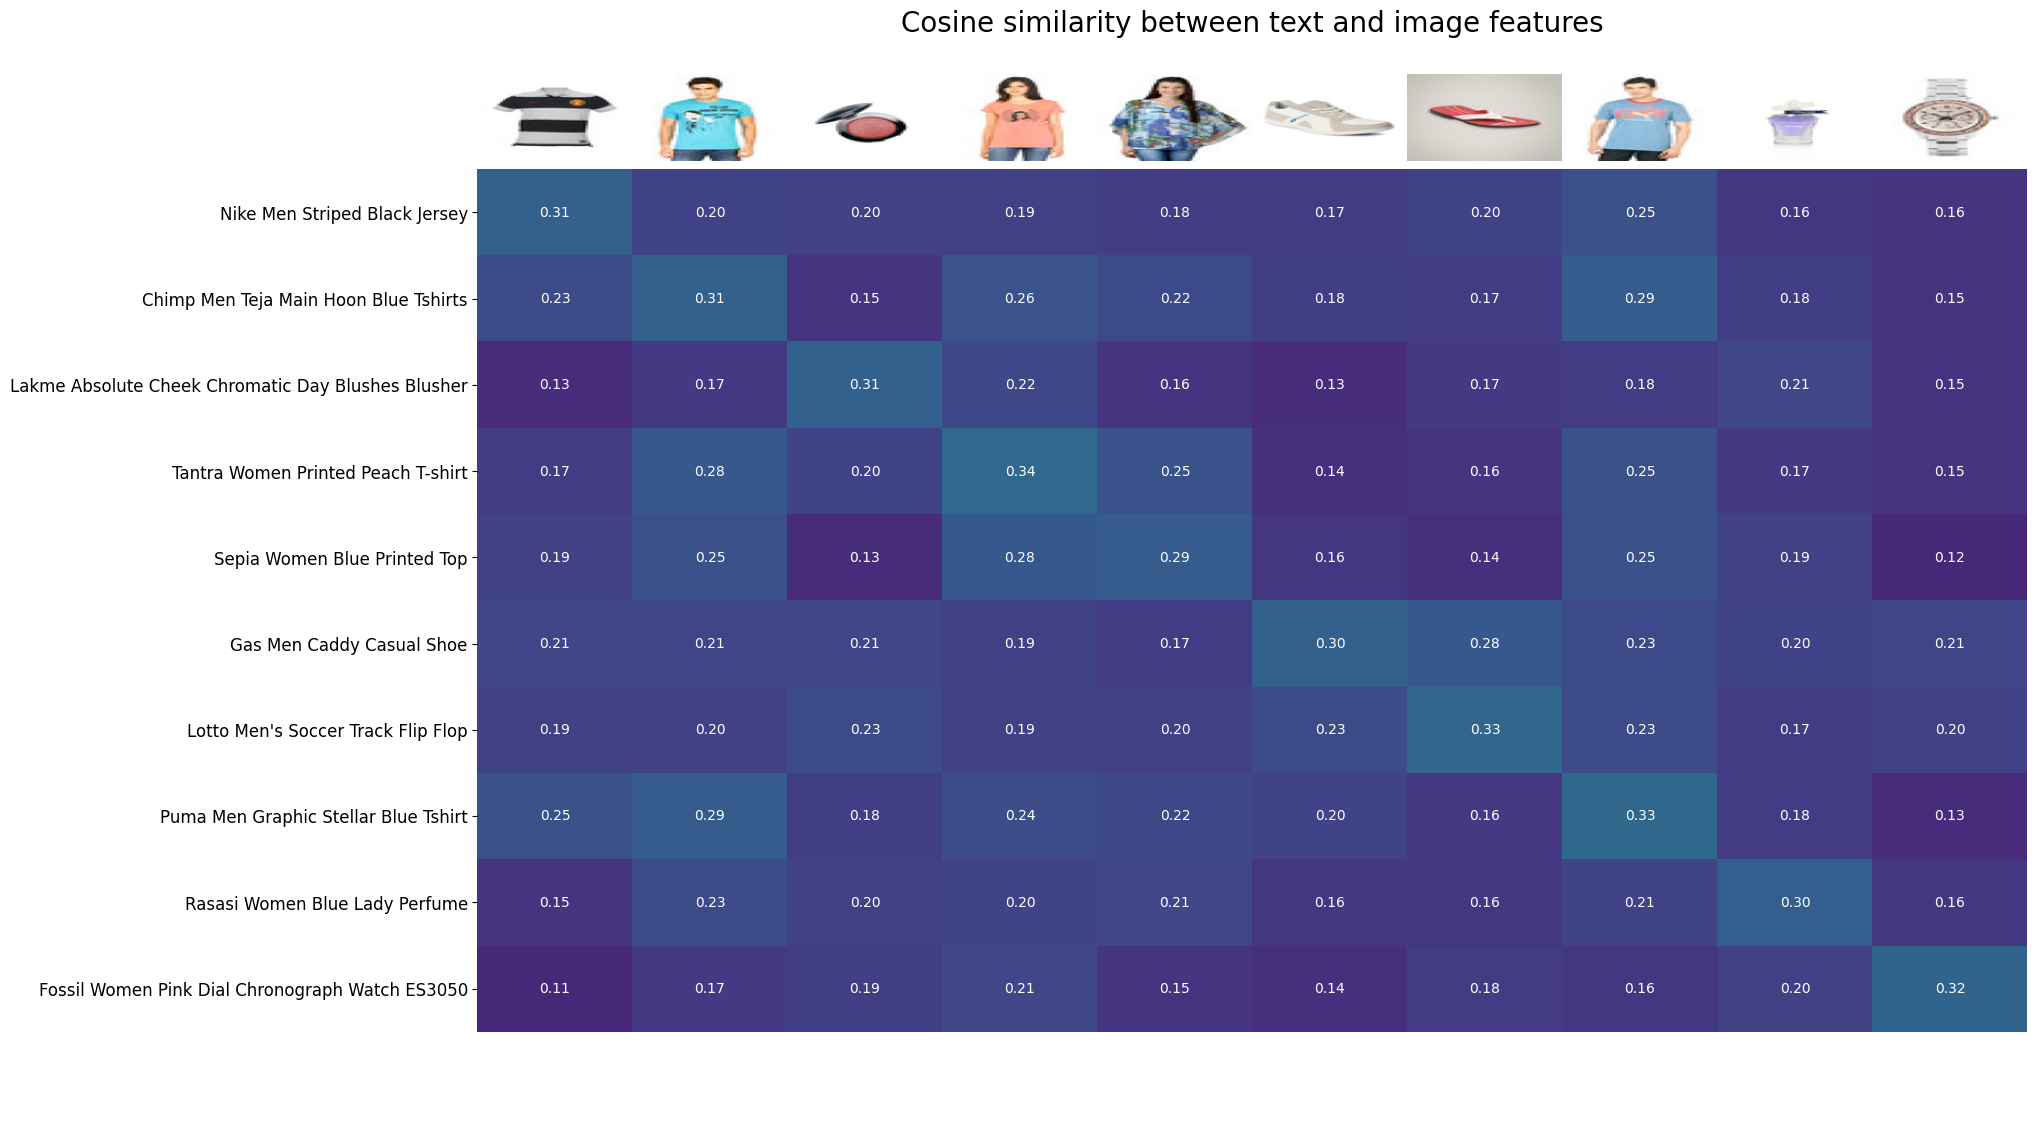

In [ ]:
import matplotlib.pyplot as plt

n = len(texts)
plt.figure(figsize=(20, 14))

# Vẽ heatmap cosine similarity
plt.imshow(similarity, cmap="viridis", vmin=0, vmax=1, origin="upper")

# Y-axis: caption
plt.yticks(range(n), texts, fontsize=12)
plt.xticks([])  # ẩn tick x

# Thêm ảnh trên trục x
for i, img in enumerate(original_images):
    plt.imshow(img, extent=(i - 0.5, i + 0.5, -0.6, -1.6), aspect='auto', zorder=1)

# Hiển thị giá trị similarity lên từng ô
for y in range(similarity.shape[0]):
    for x in range(similarity.shape[1]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", color="white", fontsize=10)

# Tắt khung xung quanh
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, n - 0.5])
plt.ylim([n + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.show()


## 7. Zero-shot classification

Number of classes in the column 'articleType': 143

Image 0 – original caption: Nike Men Striped Black Jersey
  Tunics: 0.2020
  Waistcoat: 0.1854
  Shirts: 0.1478
  Clothing Set: 0.1191
  Tops: 0.0549

Image 1 – original caption: Chimp Men Teja Main Hoon Blue Tshirts
  Lounge Tshirts: 0.3812
  Tshirts: 0.3136
  Shirts: 0.0864
  Clothing Set: 0.0429
  Tunics: 0.0266

Image 2 – original caption: Lakme Absolute Cheek Chromatic Day Blushes Blusher
  Highlighter and Blush: 0.6927
  Eyeshadow: 0.1005
  Lipstick: 0.0544
  Kajal and Eyeliner: 0.0321
  Concealer: 0.0162

Image 3 – original caption: Tantra Women Printed Peach T-shirt
  Lounge Tshirts: 0.4297
  Tshirts: 0.2281
  Nightdress: 0.1033
  Tunics: 0.0479
  Shirts: 0.0416

Image 4 – original caption: Sepia Women Blue Printed Top
  Tunics: 0.6575
  Bath Robe: 0.0824
  Camisoles: 0.0433
  Rompers: 0.0404
  Nightdress: 0.0328

Image 5 – original caption: Gas Men Caddy Casual Shoe
  Casual Shoes: 0.5329
  Sports Shoes: 0.2834
  Formal Shoes

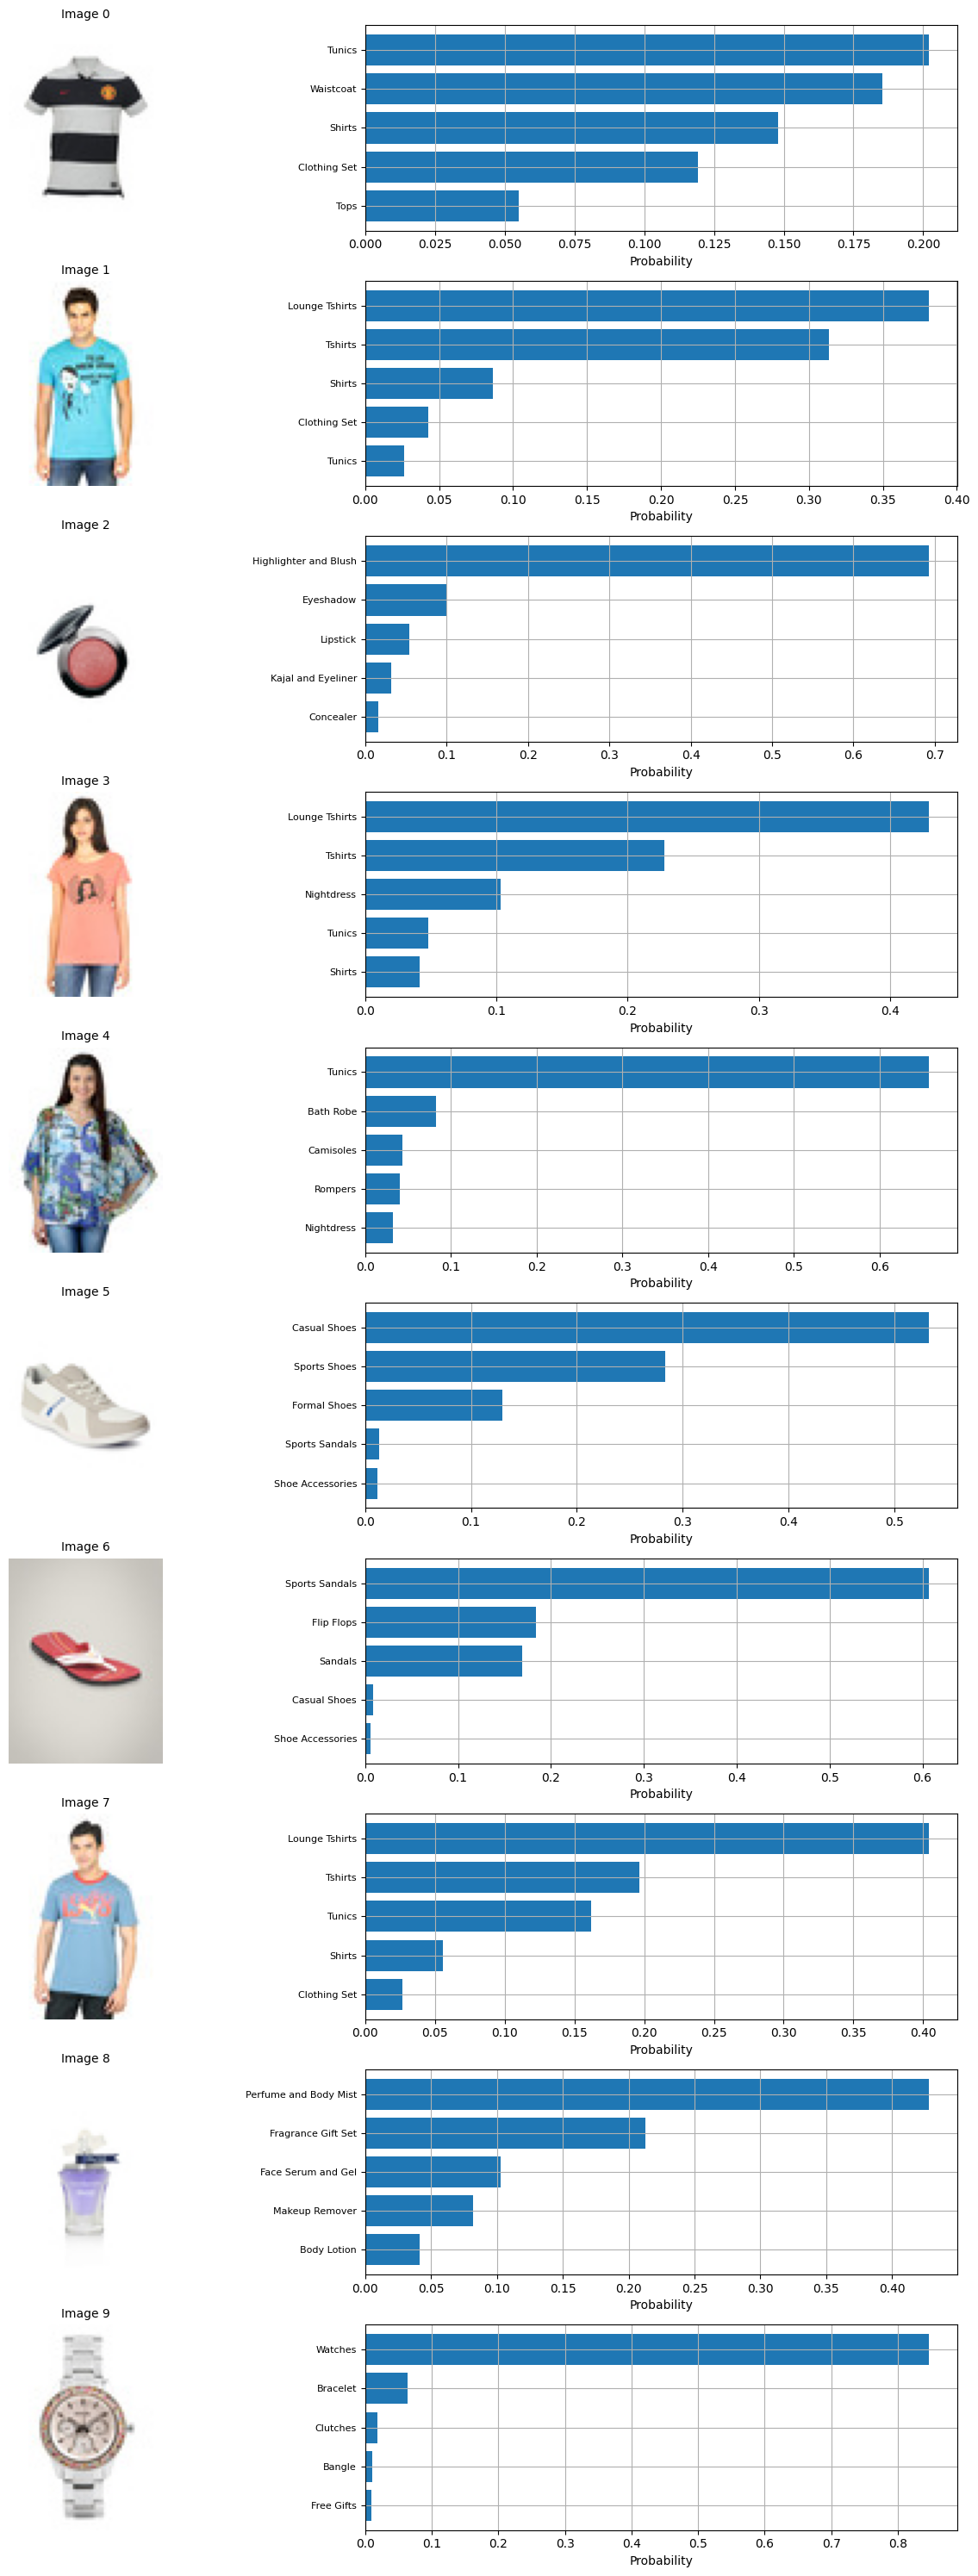

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Chọn cột nhãn để làm zero-shot (có thể đổi sang 'subCategory' hoặc 'masterCategory')
label_column = "articleType"

# Lấy danh sách class từ toàn bộ dataset
classes = (
    df[label_column]
    .dropna()
    .astype(str)
    .unique()
    .tolist()
)
classes = sorted(classes)

print(f"Number of classes in the column '{label_column}':", len(classes))

# Tạo mô tả text cho từng class rồi tokenize
text_descriptions = [f"This is a photo of a {c}" for c in classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    # Encode text bằng CLIP
    zs_text_features = model.encode_text(text_tokens).float()
    zs_text_features /= zs_text_features.norm(dim=-1, keepdim=True)

    # image_features đã được tính ở bước trước và đã normalize ở cell 21:
    # image_features /= image_features.norm(dim=-1, keepdim=True)
    # Nếu notebook bị reset và biến không còn, có thể uncomment đoạn dưới để tính lại:
    # image_input = torch.stack(images).cuda()
    # image_features = model.encode_image(image_input).float()
    # image_features /= image_features.norm(dim=-1, keepdim=True)

    # Tính logit & xác suất cho từng ảnh trên tất cả class
    logits_per_image = image_features @ zs_text_features.T
    probs = (100.0 * logits_per_image).softmax(dim=-1)  # [num_images, num_classes]

# Lấy top-5 lớp dự đoán cho mỗi ảnh
top_probs, top_labels = probs.cpu().topk(5, dim=-1)

# In kết quả dạng text
for i in range(len(original_images)):
    print(f"\nImage {i} – original caption: {texts[i]}")
    for p, cls_idx in zip(top_probs[i], top_labels[i]):
        print(f"  {classes[cls_idx]}: {p.item():.4f}")

# Vẽ ảnh + bar chart top-5 class giống notebook gốc
num_images = len(original_images)
plt.figure(figsize=(14, 3 * num_images))

for i, img in enumerate(original_images):
    # Ảnh gốc
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i}", fontsize=10)

    # Bar chart top-5 class
    plt.subplot(num_images, 2, 2 * i + 2)
    y = np.arange(5)
    plt.grid(True)
    plt.barh(y, top_probs[i].numpy())
    plt.gca().invert_yaxis()
    plt.yticks(y, [classes[idx] for idx in top_labels[i].numpy()], fontsize=8)
    plt.xlabel("Probability")

plt.tight_layout()
plt.show()

# 8. Contrastive / InfoNCE loss

In [ ]:
import torch
import torch.nn.functional as F

batch_size = image_features.shape[0]
device = image_features.device

# logit_scale là tham số temperature đã được học trong CLIP
# model.logit_scale là log scale, nên cần exp() để đưa về giá trị dương
logit_scale = model.logit_scale.exp()

# Tính logits (similarity * temperature) hai chiều image->text và text->image
logits_per_image = logit_scale * image_features @ text_features.t()
logits_per_text  = logits_per_image.t()

# Nhãn đúng: ảnh i khớp với caption i
targets = torch.arange(batch_size, device=device)

# InfoNCE / contrastive loss như CLIP paper:
#   L = (CE(img->text) + CE(text->img)) / 2
loss_i2t = F.cross_entropy(logits_per_image, targets)
loss_t2i = F.cross_entropy(logits_per_text, targets)
loss = (loss_i2t + loss_t2i) / 2.0

print(f"Image → Text loss: {loss_i2t.item():.4f}")
print(f"Text  → Image loss: {loss_t2i.item():.4f}")
print(f"Contrastive InfoNCE loss (avg): {loss.item():.4f}")

pred_i2t = logits_per_image.argmax(dim=-1)  # dự đoán caption cho mỗi ảnh
pred_t2i = logits_per_text.argmax(dim=-1)   # dự đoán ảnh cho mỗi caption

acc_i2t = (pred_i2t == targets).float().mean().item()
acc_t2i = (pred_t2i == targets).float().mean().item()

print(f"Image → Text accuracy: {acc_i2t * 100:.2f}%")
print(f"Text  → Image accuracy: {acc_t2i * 100:.2f}%")


Image → Text loss: 0.0282
Text  → Image loss: 0.0514
Contrastive InfoNCE loss (avg): 0.0398
Image → Text accuracy: 100.00%
Text  → Image accuracy: 100.00%


# 9. Export Model

In [ ]:
import torch
import json

export_path = "clip_fashion_export.pt"
labels_path = "clip_fashion_labels.json"

# Lưu file .pt chứa text_features
torch.save(
    {
        "model_name": "ViT-B/32",
        "classes": classes,
        "zs_text_features": zs_text_features.cpu(),
        "state_dict": model.state_dict()
    },
    export_path,
)
print("Saved:", export_path)

with open(labels_path, "w", encoding="utf-8") as f:
    json.dump(classes, f, ensure_ascii=False, indent=2)
print("Saved:", labels_path)

Saved: clip_fashion_export.pt
Saved: clip_fashion_labels.json
